In [65]:
from transformers import pipeline
from germansentiment import SentimentModel
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')
tqdm.pandas()
sns.set_theme()

# Loading and Preprocessing of Swissvotes Dataset 

In [2]:
data = pd.read_excel('./data/DATASET XLSX 06-07-2023.xlsx', sheet_name='DATA')

In [3]:
data.head()

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,stichwort,swissvoteslink,anzahl,rechtsform,...,ju-nein,ju-japroz,ju-annahme,bkresults-de,bkresults-fr,bfsmap-de,bfsmap-fr,nach_cockpit_d,nach_cockpit_f,nach_cockpit_e
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,.,https://swissvotes.ch/vote/1.00,1,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18480606/...,https://www.bk.admin.ch/ch/f/pore/va/18480606/...,NaN,NaN,.,.,.
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,.,https://swissvotes.ch/vote/2.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,.,https://swissvotes.ch/vote/3.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",.,https://swissvotes.ch/vote/4.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,.,https://swissvotes.ch/vote/5.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.


## Preprocessing oucome analysis for German and French Cantons

In [4]:
def get_german_outcome(row):
    #row = row.fillna(0)
    row = row.replace('.', np.nan)
    yes = sum(row[['sh-ja', 'tg-ja', 'lu-ja', 'sz-ja', 'zh-ja', 'be-ja', 'gr-ja', 'gl-ja', 'so-ja', 'ag-ja', 'bl-ja', 'bs-ja', 'ow-ja', 'nw-ja', 'sg-ja', 'ur-ja']])
    no = sum(row[['sh-nein', 'tg-nein', 'lu-nein', 'sz-nein', 'zh-nein', 'be-nein', 'gr-nein', 'gl-nein', 'so-nein', 'ag-nein', 'bl-nein', 'bs-nein', 'ow-nein', 'nw-nein', 'sg-nein', 'ur-nein']])
    if yes == 0 or no == 0:
        return int((sum(row[['sh-annahme', 'tg-annahme', 'lu-annahme', 'sz-annahme', 'zh-annahme', 'be-annahme', 'gr-annahme', 'gl-annahme', 'so-annahme', 'ag-annahme', 'bl-annahme', 'bs-annahme', 'ow-annahme', 'nw-annahme', 'sg-annahme', 'ur-annahme']])/16) > 0.5), yes , no
    if yes > no:
        return 1, yes, no
    else:
        return 0, yes, no


def get_fr_outcome(row):
    #substitute . with 0 and np.nan with 0 in order to be able to sum
    #row = row.fillna(0)
    row = row.replace('.', np.nan)
    yes = sum(row[['fr-ja', 'ge-ja', 'vs-ja', 'vd-ja', 'ne-ja', 'ju-ja']])
    no = sum(row[['fr-nein', 'ge-nein', 'vs-nein', 'vd-nein', 'ne-nein', 'ju-nein']])
    if yes == 0 or no == 0:
        return int((sum(row[['fr-annahme', 'ge-annahme', 'vs-annahme', 'vd-annahme', 'ne-annahme', 'ju-annahme']])/6) > 0.5), yes , no
    if yes > no:
        return 1, yes, no
    else:
        return 0, yes, no

In [5]:
data['german_outcome'] = data.apply(lambda x: get_german_outcome(x)[0], axis=1)
data['french_outcome'] = data.apply(lambda x: get_fr_outcome(x)[0], axis=1)
data['german_yes'] = data.apply(lambda x: get_german_outcome(x)[1], axis=1)
data['german_no'] = data.apply(lambda x: get_german_outcome(x)[2], axis=1)
data['french_yes'] = data.apply(lambda x: get_fr_outcome(x)[1], axis=1)
data['french_no'] = data.apply(lambda x: get_fr_outcome(x)[2], axis=1)

# Data Exploration

In [6]:
annahme_columns = [col for col in data.columns if 'annahme' in col]
annahme_data = data[annahme_columns]
annahme_data.fillna(100, inplace=True)
annahme_data.replace('.', 100, inplace=True)

counts = annahme_data.apply(pd.Series.value_counts)
ratios = counts.loc[1] / counts.loc[0]
ratios.sort_values(ascending=False, inplace=True)

top = ratios.head(3)
bottom = ratios.tail(3)

In [7]:
counts

,annahme,zh-annahme,be-annahme,lu-annahme,ur-annahme,sz-annahme,ow-annahme,nw-annahme,gl-annahme,zg-annahme,...,sg-annahme,gr-annahme,ag-annahme,tg-annahme,ti-annahme,vd-annahme,vs-annahme,ne-annahme,ge-annahme,ju-annahme
0,357.0,306.0,335.0,350.0,381.0,429.0,392.0,375.0,355.0,363.0,...,370.0,343.0,363.0,351.0,313.0,326.0,398.0,323.0,302.0,184.0
1,323.0,374.0,345.0,330.0,299.0,251.0,288.0,305.0,325.0,317.0,...,310.0,337.0,317.0,329.0,367.0,354.0,282.0,357.0,378.0,193.0
8,NaN,3.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0
9,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,...,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
100,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.0


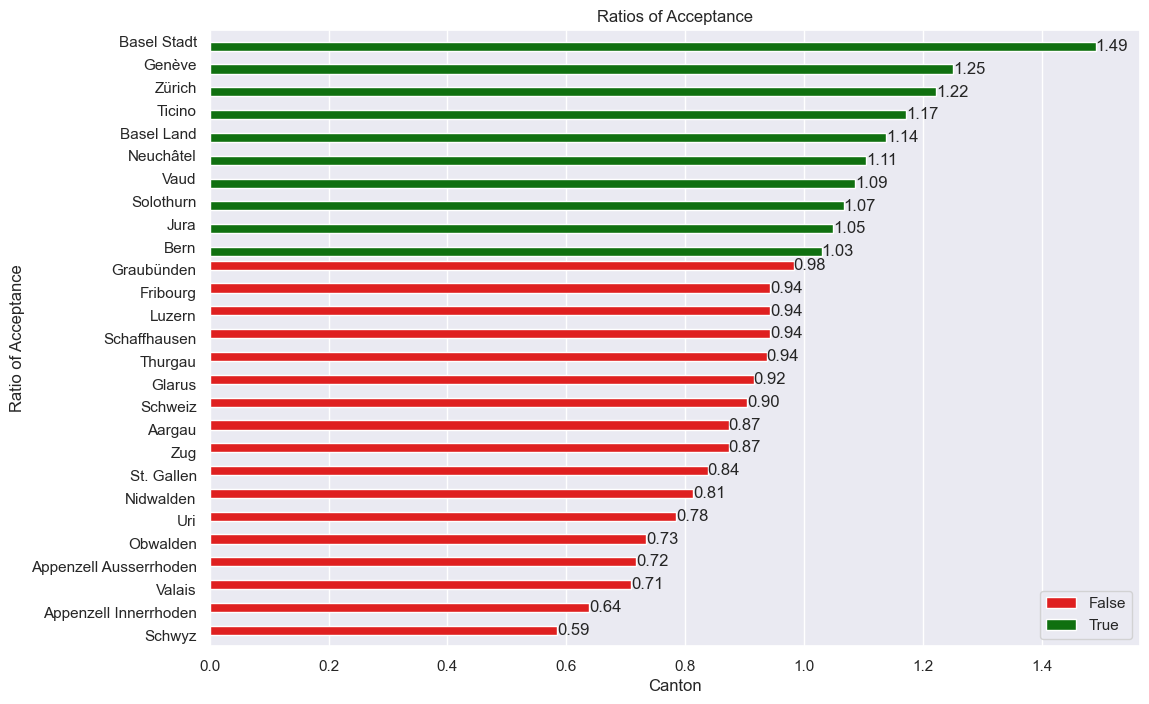

In [66]:
fig, axs = plt.subplots(figsize=(12,8))
sns.set_color_codes("muted")
sns.barplot(y=ratios.index, x=ratios.values, ax=axs, hue=ratios.values>1, palette=['red', 'green'])
axs.set_title('Ratios of Acceptance')
axs.set_ylabel('Ratio of Acceptance')
axs.set_xlabel('Canton')
axs.set_yticklabels(['Basel Stadt', 'Genève', 'Zürich', 'Ticino', 'Basel Land', 'Neuchâtel', 'Vaud', 'Solothurn', 'Jura', 'Bern', 'Graubünden', 'Fribourg', 'Luzern', 'Schaffhausen', 'Thurgau', 'Glarus', 'Schweiz', 'Aargau', 'Zug', 'St. Gallen', 'Nidwalden', 'Uri', 'Obwalden', 'Appenzell Ausserrhoden', 'Valais', 'Appenzell Innerrhoden', 'Schwyz'])
for i in axs.containers:
    axs.bar_label(i, fmt='%.2f', label_type='edge')
plt.savefig('./figures/acceptance_ratios_tot.pdf', format='pdf', bbox_inches='tight')

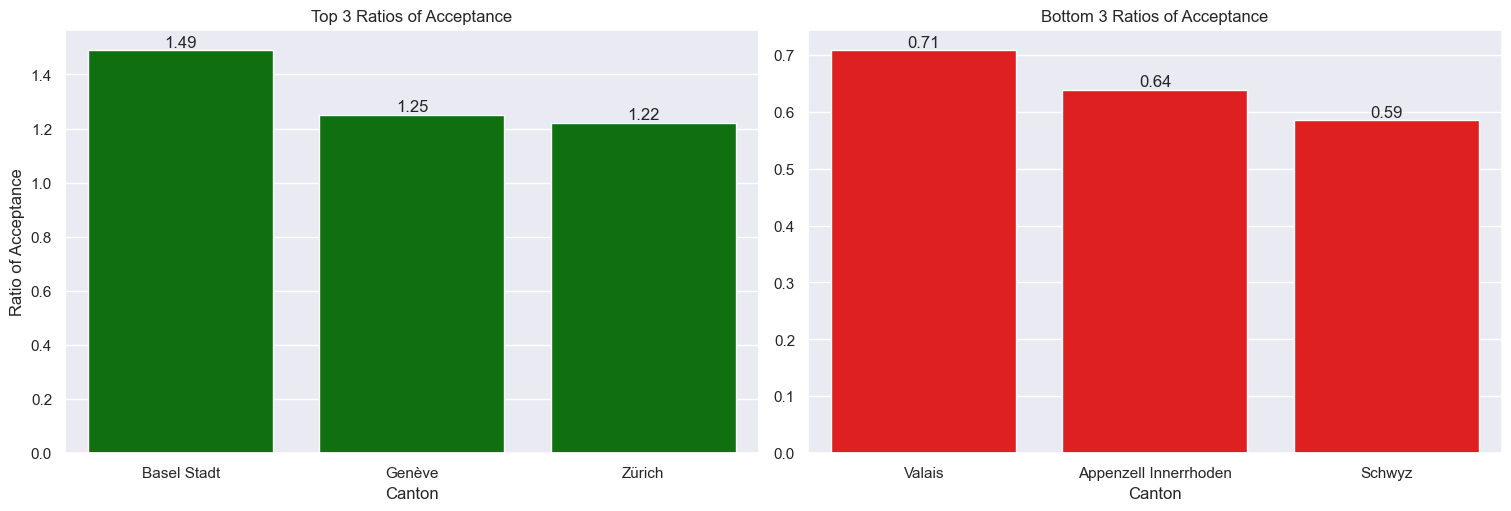

In [67]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.barplot(x=top.index, y=top.values, ax=axs[0], color='green')
axs[0].set_title('Top 3 Ratios of Acceptance')
axs[0].set_ylabel('Ratio of Acceptance')
axs[0].set_xlabel('Canton')
axs[0].set_xticklabels(['Basel Stadt', 'Genève', 'Zürich'])
for i in axs[0].containers:
    axs[0].bar_label(i, fmt='%.2f', label_type='edge')

sns.barplot(x=bottom.index, y=bottom.values, ax=axs[1], color='red')
axs[1].set_title('Bottom 3 Ratios of Acceptance')
axs[1].set_xlabel('Canton')
axs[1].set_xticklabels(['Valais', 'Appenzell Innerrhoden', 'Schwyz'])
for i in axs[1].containers:
    axs[1].bar_label(i, fmt='%.2f', label_type='edge')
plt.savefig('./figures/acceptance_ratios3.pdf', format='pdf', bbox_inches='tight')

In [10]:
beteiligung_columns = [col for col in data.columns if 'bet' in col]
beteiligung_columns.append('anr')
beteiligung_data = data[beteiligung_columns]
beteiligung_data.drop(columns=['kurzbetitel'], inplace=True)
beteiligung_data.replace('.', np.nan, inplace=True)

In [11]:
dfm = beteiligung_data[['bet', 'zh-bet', 'ge-bet', 'sz-bet', 'anr']].melt('anr', var_name='cols', value_name='vals')

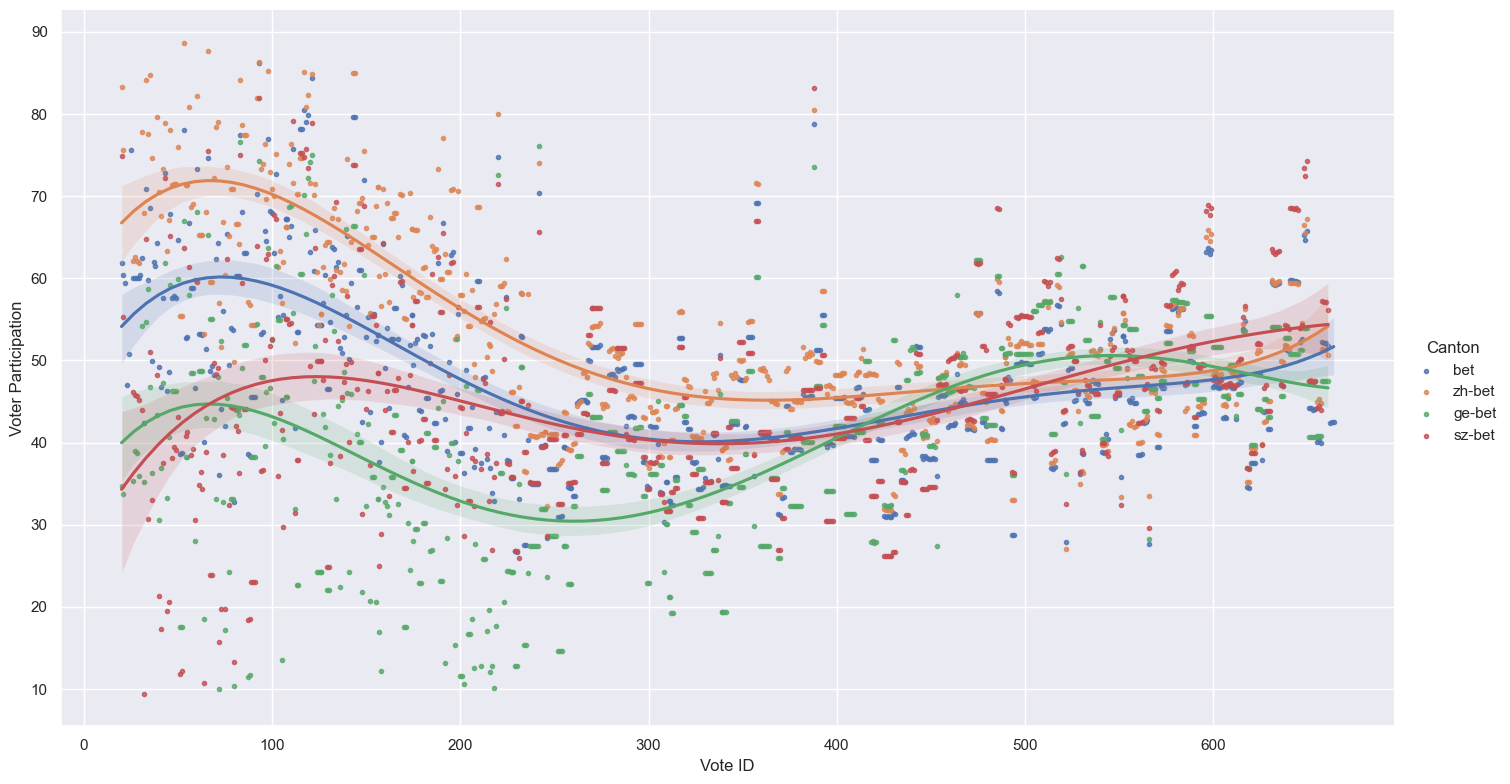

In [68]:
#fig, axs = plt.subplots(figsize=(24,12))
g = sns.lmplot(x='anr', y='vals', data=dfm, hue='cols', order=5, scatter=True, markers=[".", ".", ".", "."], height=8, aspect=1.7777777)
g.set_ylabels('Voter Participation')
g.set_xlabels('Vote ID')
g._legend.set_title('Canton')
plt.savefig('./figures/beteiligung.pdf', format='pdf', bbox_inches='tight')

# Sentiment Analysis

In [13]:
text_data = data[['anr', 'datum', 'titel_kurz_d', 'titel_kurz_f', 'titel_off_d', 'titel_off_f', 'german_outcome', 'french_outcome', 'german_yes', 'german_no', 'french_yes', 'french_no']]

## Sentiment Analysis Seperate for German and French Vote Titles

### Similarity between German and French Vote Titles

In [14]:
model_similarity = SentenceTransformer('distiluse-base-multilingual-cased-v1')
def get_title_similarity(row):
    german_embedding = model_similarity.encode([row['titel_off_d']])
    french_embedding = model_similarity.encode([row['titel_off_f']])
    similarity = cosine_similarity(german_embedding, french_embedding)[0][0]
    return similarity

In [17]:
text_data['title_similarity'] = text_data.progress_apply(get_title_similarity, axis=1)

  0%|          | 0/683 [00:00<?, ?it/s]

100%|██████████| 683/683 [00:31<00:00, 21.43it/s]


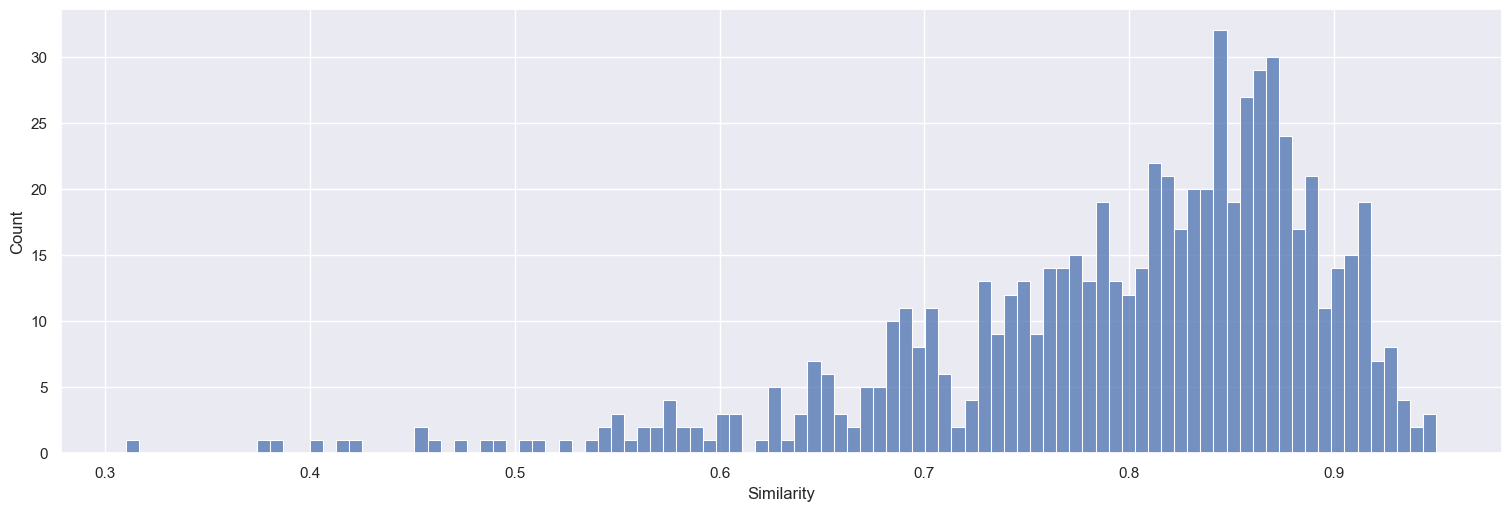

In [69]:
fig, axs = plt.subplots(nrows=1,ncols=1, layout='constrained',figsize=(15,5))
sns.histplot(data=text_data, x='title_similarity', bins=100, ax=axs)
axs.set_label('Vote Title Similarity')
axs.set_xlabel('Similarity')
axs.set_ylabel('Count')
plt.savefig('./figures/title_similarity.pdf', format='pdf', bbox_inches='tight')

In [21]:
analyzer_fr = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment")
model_de = SentimentModel()

def get_fr_sentiment(text):
    result = analyzer_fr(text, return_all_scores=True)
    res = 0
    for i in range(len(result[0])):
        if i < 2:
            res -= result[0][i]['score']
        elif i==2:
            continue
        elif i > 2:
            res += result[0][i]['score']
    return res
def get_de_sentiment(text):
    res = 0
    classes, probabilities = model_de.predict_sentiment([text], output_probabilities=True)
    for i in range(len(probabilities[0])):
        if i == 0:
            res += probabilities[0][i][1]
        elif i==1:
            res -= probabilities[0][i][1]
        elif i == 2:
            continue
    return res

In [22]:
tqdm.pandas()
text_data['sentiment_d'] = text_data['titel_off_d'].progress_apply(get_de_sentiment)
text_data['sentiment_fr'] = text_data['titel_off_f'].progress_apply(get_fr_sentiment)

100%|██████████| 683/683 [00:15<00:00, 45.04it/s]


<Axes: xlabel='sentiment_fr', ylabel='Count'>

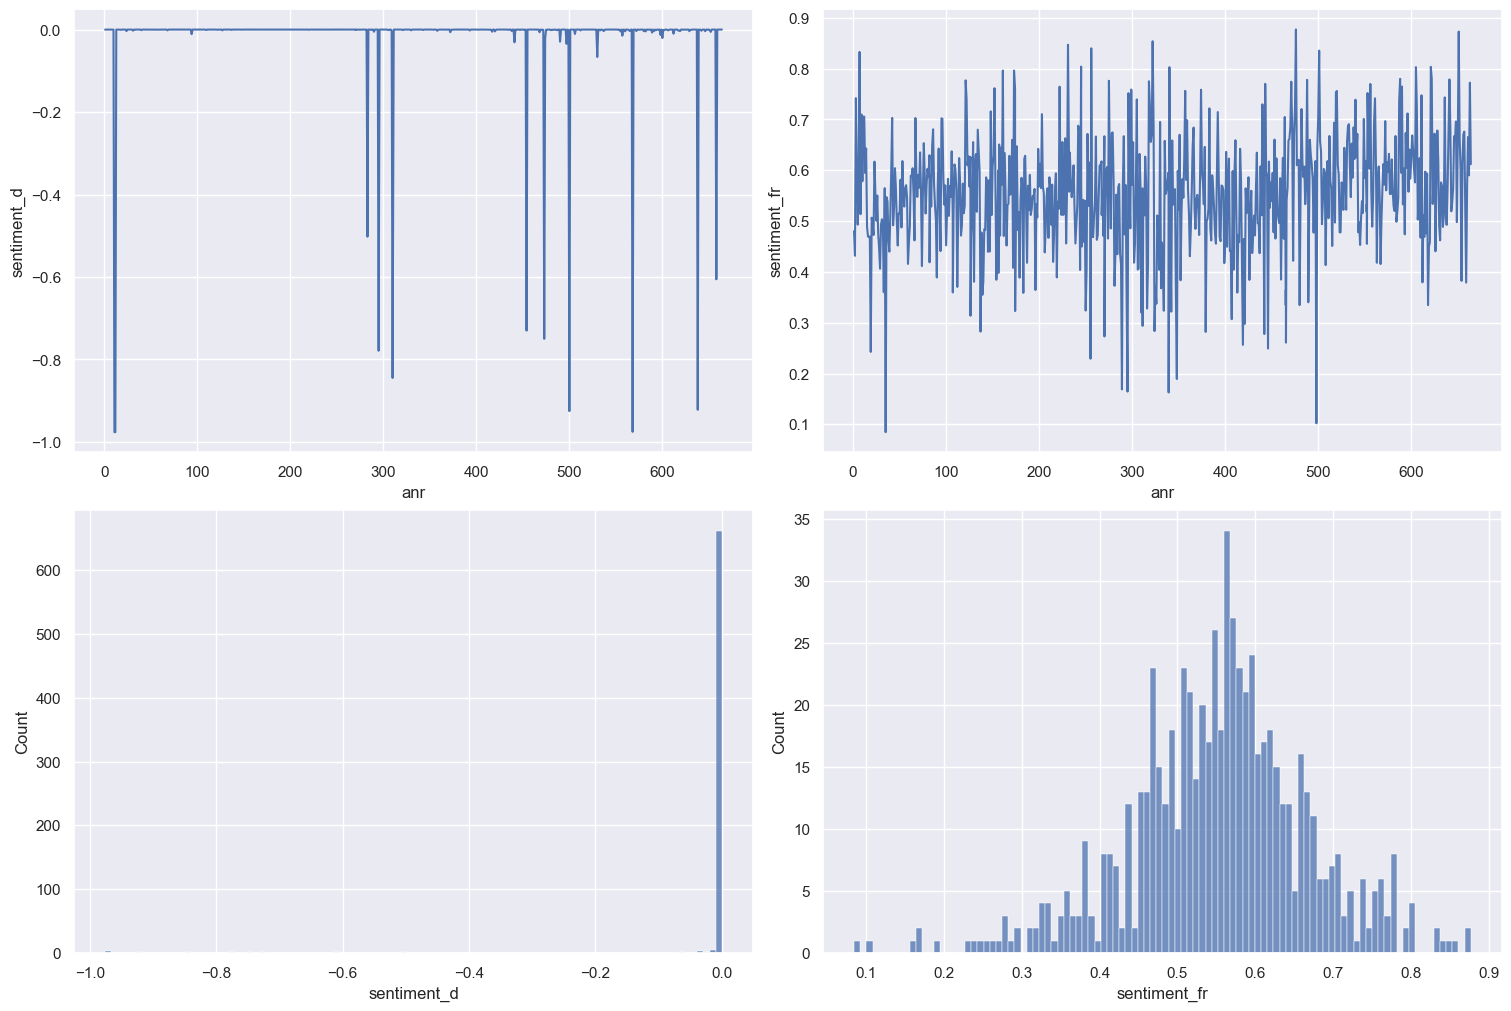

In [72]:
fig, axs = plt.subplots(nrows=2,ncols=2, layout='constrained',figsize=(15,10))
sns.lineplot(data=text_data, x='anr', y="sentiment_d", ax=axs[0][0])
sns.lineplot(data=text_data, x='anr', y="sentiment_fr", ax=axs[0][1])
sns.histplot(data=text_data, x='sentiment_d', bins=100, ax=axs[1][0])
sns.histplot(data=text_data, x='sentiment_fr', bins=100, ax=axs[1][1])

In [73]:
from transformers import pipeline

# Create a sentiment analysis pipeline
sentiment_classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Define a list of texts in different languages
texts = [
    "Je déteste ce livre",
    "ich hasse dieses Buch",
]

# Analyze sentiment for each text
for text in texts:
    result = sentiment_classifier(text, return_all_scores=True)
    print(result)
    #score = result[0]['score']
    #sentiment = result[0]['label']
    #print(f"Text: {text}")
    #print(f"Score: {score}")
    #print(f"Sentiment: {sentiment}")
    #print("\n")


[[{'label': '1 star', 'score': 0.5975852012634277}, {'label': '2 stars', 'score': 0.2852255403995514}, {'label': '3 stars', 'score': 0.09172043949365616}, {'label': '4 stars', 'score': 0.014224903658032417}, {'label': '5 stars', 'score': 0.01124395988881588}]]
[[{'label': '1 star', 'score': 0.015174048952758312}, {'label': '2 stars', 'score': 0.010292411781847477}, {'label': '3 stars', 'score': 0.04501724988222122}, {'label': '4 stars', 'score': 0.20721517503261566}, {'label': '5 stars', 'score': 0.7223011255264282}]]


In [57]:
sentiment = pipeline(task="sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
def get_bert_label(text):
    return sentiment(text)[0]['label']
def get_bert_score(text):
    tmp_sentiment = sentiment(text, return_all_scores=True)
    return -tmp_sentiment[0][0]['score']-tmp_sentiment[0][1]['score']+tmp_sentiment[0][3]['score']+tmp_sentiment[0][4]['score']
def get_bert(text):
    return sentiment(text)[0]

In [58]:
#text_data['sentiment_d_bert_label'] = text_data['titel_off_d'].progress_apply(get_bert_label)
#text_data['sentiment_fr_bert_label'] = text_data['titel_off_f'].progress_apply(get_bert_label)
text_data['sentiment_d_bert_score'] = text_data['titel_off_d'].progress_apply(get_bert_score)
text_data['sentiment_fr_bert_score'] = text_data['titel_off_f'].progress_apply(get_bert_score)

100%|██████████| 683/683 [00:26<00:00, 26.00it/s]


In [59]:
text_data.head(10)

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,german_outcome,french_outcome,german_yes,german_no,french_yes,french_no,title_similarity,sentiment_d,sentiment_fr,sentiment_d_bert_label,sentiment_fr_bert_label,sentiment_d_bert_score,sentiment_fr_bert_score
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,0,0,NaN,NaN,NaN,NaN,0.913938,-0.000054,0.480089,1 star,1 star,-0.850861,-0.301526
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,0,0,109359.0,122755.0,NaN,NaN,0.739839,-0.000044,0.431590,4 stars,5 stars,0.690028,0.665731
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,1,0,121463.0,113453.0,NaN,NaN,0.376547,-0.000003,0.741770,4 stars,4 stars,0.378077,0.674073
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",0,0,116454.0,118203.0,NaN,NaN,0.701087,-0.000009,0.597496,4 stars,5 stars,0.572135,0.535506
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,0,0,109031.0,122893.0,NaN,NaN,0.522434,-0.000011,0.492853,5 stars,5 stars,0.672129,0.500753
5,6.0,14.01.1866,Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",1,0,122108.0,112788.0,NaN,NaN,0.700256,-0.000005,0.605837,4 stars,5 stars,0.465268,0.558619
6,7.0,14.01.1866,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,0,0,114067.0,119719.0,NaN,NaN,0.829270,0.000266,0.832642,5 stars,5 stars,0.838675,0.778392
7,8.0,14.01.1866,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,0,0,90482.0,142202.0,NaN,NaN,0.572884,-0.000210,0.513442,3 stars,1 star,0.144190,-0.565871
8,9.0,14.01.1866,Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",0,0,110732.0,120427.0,NaN,NaN,0.488191,-0.000005,0.709514,5 stars,5 stars,0.741163,0.823532
9,10.0,14.01.1866,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,0,0,115219.0,116569.0,NaN,NaN,0.840769,-0.000143,0.578163,1 star,1 star,-0.588171,-0.517892


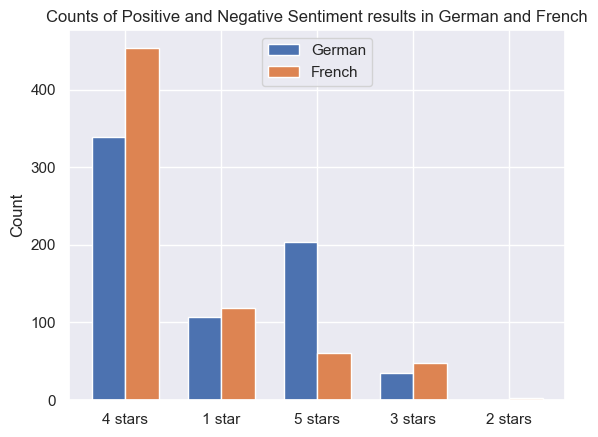

In [74]:
column1_counts = text_data['sentiment_d_bert_label'].value_counts()
column2_counts = text_data['sentiment_fr_bert_label'].value_counts()
if len(column1_counts) < len(column2_counts):
    column1_counts = column1_counts.reindex(column2_counts.index)
fig, ax = plt.subplots()
x = range(len(column1_counts))
width = 0.35

rects1 = ax.bar(x, column1_counts, width, label='German')
rects2 = ax.bar([i + width for i in x], column2_counts, width, label='French')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(column1_counts.index)

ax.set_ylabel('Count')
ax.set_title('Counts of Positive and Negative Sentiment results in German and French')
ax.legend()

plt.show()


<Axes: xlabel='sentiment_fr_bert_score', ylabel='Count'>

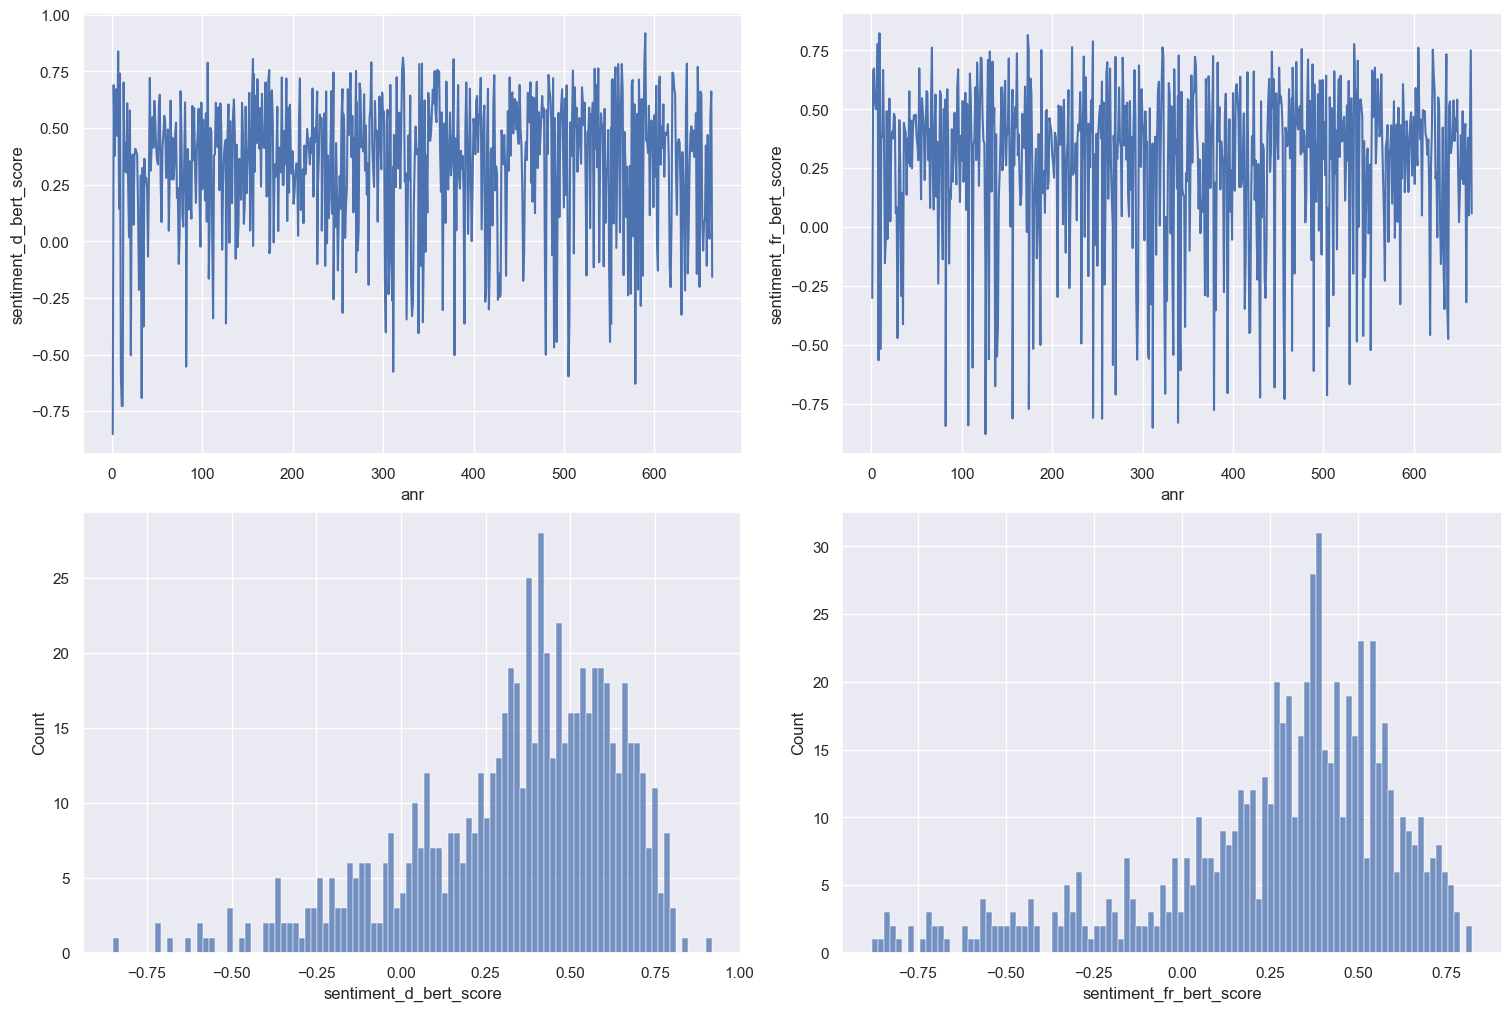

In [75]:
fig, axs = plt.subplots(nrows=2,ncols=2, layout='constrained',figsize=(15,10))
sns.lineplot(data=text_data, x='anr', y="sentiment_d_bert_score", ax=axs[0][0])
sns.lineplot(data=text_data, x='anr', y="sentiment_fr_bert_score", ax=axs[0][1])
sns.histplot(data=text_data, x='sentiment_d_bert_score', bins=100, ax=axs[1][0])
sns.histplot(data=text_data, x='sentiment_fr_bert_score', bins=100, ax=axs[1][1])

<Axes: xlabel='anr', ylabel='sentiment_fr_bert_score'>

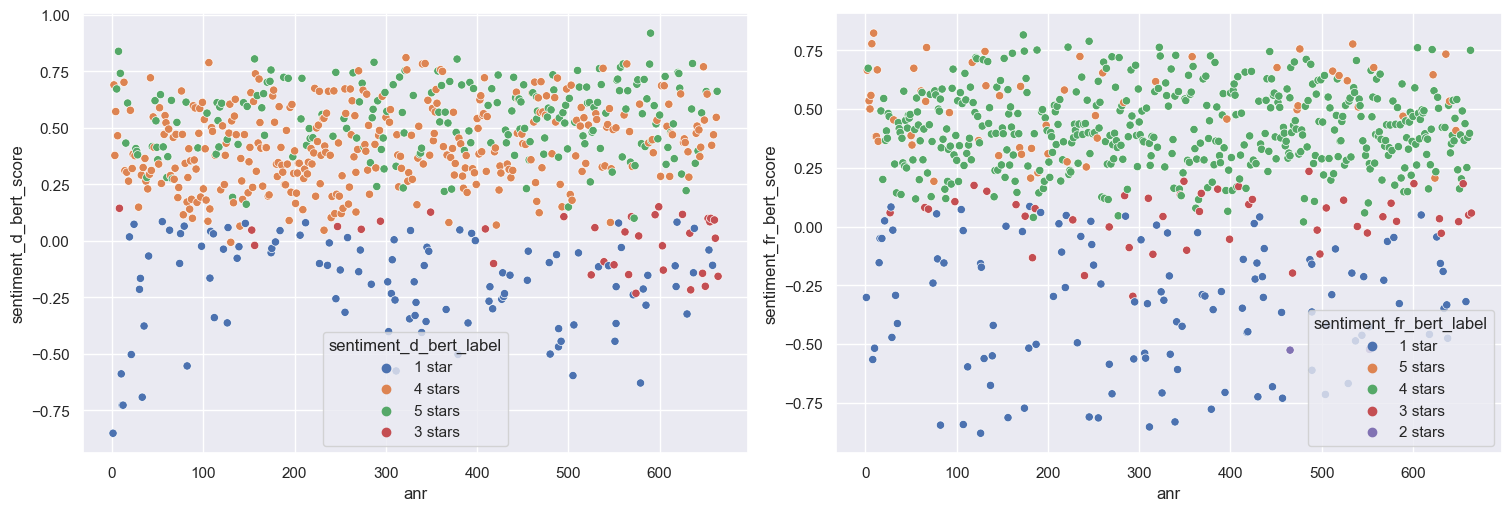

In [76]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.scatterplot(data=text_data, x='anr', y='sentiment_d_bert_score', hue='sentiment_d_bert_label', ax=axs[0])
sns.scatterplot(data=text_data, x='anr', y='sentiment_fr_bert_score', hue='sentiment_fr_bert_label', ax=axs[1])

In [ ]:
text_data.describe()

In [316]:
from textblob import TextBlob
text_data['sentiment_d_textblob'] = text_data['titel_off_d'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
text_data['sentiment_fr_textblob'] = text_data['titel_off_f'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

  0%|          | 0/683 [00:00<?, ?it/s]

100%|██████████| 683/683 [00:00<00:00, 12416.18it/s]


In [321]:
text_data[['sentiment_d_textblob','sentiment_fr_textblob']].describe()

,sentiment_d_textblob,sentiment_fr_textblob
count,683.000000,683.000000
mean,0.002635,-0.001077
std,0.040074,0.063804
min,0.000000,-0.800000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.700000,0.400000
